In [2]:
# Mount Google Drive (if you want to save changes)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: False
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-sg_suc0f
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-sg_suc0f
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2025-01-18 13:19:59--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.51, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘../checkpoints/sam2.1_hiera_l

In [8]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

using device: cpu


Define inference object

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

Load video and setup trackable targets

In [10]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/content/drive/MyDrive/viot/pm1_50"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

inference_state = predictor.init_state(video_path=video_dir)

predictor.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 50/50 [00:02<00:00, 19.52it/s]


Setup trackable targets

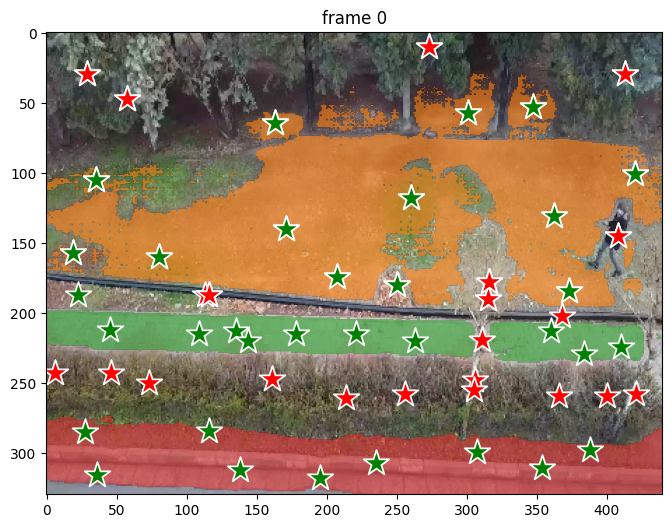

In [26]:
prompts = {}  # hold all the clicks we add for visualization

# add the first object
ann_frame_idx = 0  # the frame index we interact with

# give a unique id to each object we interact with (it can be any integers)
# Let's add a 2nd negative click at (x, y) = (275, 175) to refine the first object
# sending all clicks (and their labels) to `add_new_points_or_box`
# for labels, `1` means positive click and `0` means negative click



ann_obj_id = 2
points = np.array([[45, 212], [22, 187], [135, 213], [178, 215], [144, 220], [263, 220], [384, 229], [360, 213], [410, 224], [221, 215], [109, 215], [311, 219], [46, 243], [161, 247], [305, 255], [256, 258], [400, 259], [113, 187], [368, 202]], dtype=np.float32)
labels = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], np.int32)
prompts[ann_obj_id] = points, labels


ann_obj_id = 3
points = np.array([[27, 285], [36, 316], [116, 284], [138, 312], [235, 307], [354, 311], [388, 298], [307, 299], [195, 318], [214, 261], [73, 250], [366, 259], [306, 248], [6, 243], [421, 258]], dtype=np.float32)
labels = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], np.int32)
prompts[ann_obj_id] = points, labels

ann_obj_id = 1
points = np.array([[35, 105], [19, 157], [80, 160], [163, 64], [171, 140], [260, 118], [301, 57], [347, 53], [362, 131], [207, 174], [250, 180], [373, 184], [420, 101], [315, 190], [316, 178], [408, 145], [57, 47], [29, 29], [273, 10], [116, 187], [413, 29]], dtype=np.float32)
labels = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], np.int32)
prompts[ann_obj_id] = points, labels

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

Track the segments in the video

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results
# plt.close("all")
import cv2
for out_frame_idx in range(0, len(frame_names)):
    # plt.figure(figsize=(6, 4))
    # plt.title(f"frame {out_frame_idx}")
    # plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        cv2.imwrite(os.path.join(video_dir, frame_names[out_frame_idx])[:-4]+"_mask.jpg", out_mask)

propagate in video:  52%|█████▏    | 26/50 [33:11<33:23, 83.48s/it]